# Import Packages

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read Images

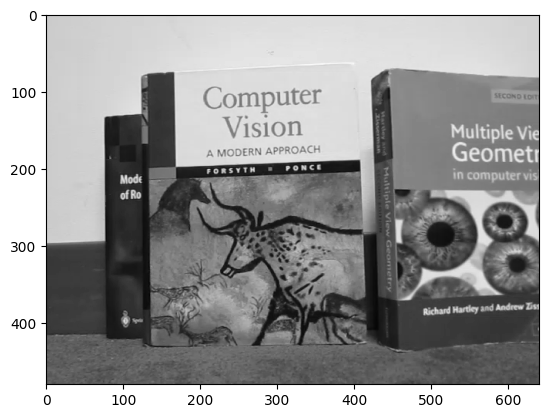

In [28]:
# Load the book image
book_img = cv2.imread('../assignment_2_materials/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)

# Show the book image
plt.imshow(book_img, cmap='grey')

# Load the first frame from the video
cap = cv2.VideoCapture('../assignment_2_materials/book.mov')
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Could not read the first frame of the video.")

frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Show the first frame
plt.imshow(frame_gray, 'grey')

# Detecting Keypoints

In [29]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect and compute keypoints/descriptors
kp1, des1 = sift.detectAndCompute(book_img, None)
kp2, des2 = sift.detectAndCompute(frame_gray, None)

# Matching Descriptors

In [30]:
# Brute-force matcher with L2 norm and KNN
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Sort by distance and keep top 50
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

# Visualize the matches

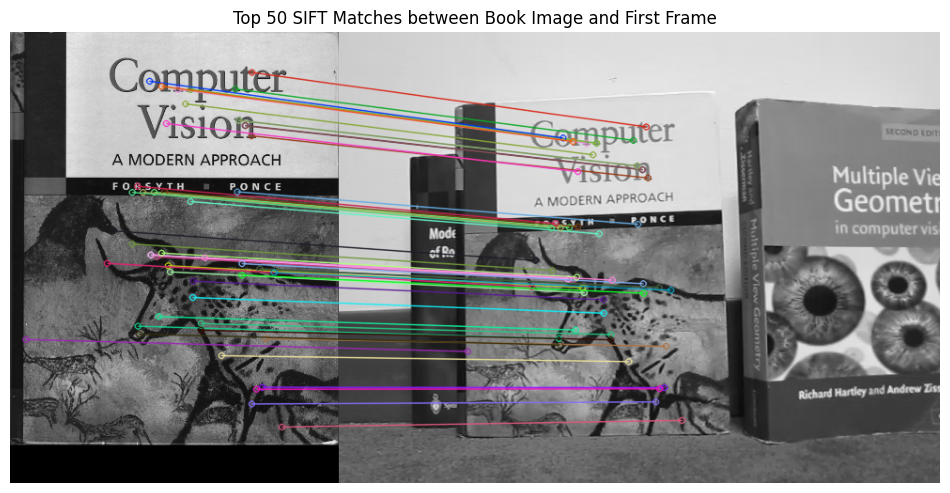

In [31]:
# Draw matches
matched_img = cv2.drawMatches(book_img, kp1, frame_gray, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show result
plt.figure(figsize=(12, 6))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 SIFT Matches between Book Image and First Frame")
plt.axis('off')
plt.show()

# Compute the Homography Parameters

Homography Matrix:
 [[ 7.73175746e-01  2.75722288e-03  1.19569964e+02]
 [-5.11103674e-02  7.78602152e-01  7.74981416e+01]
 [-9.11956120e-05 -7.43420640e-05  1.00000000e+00]]


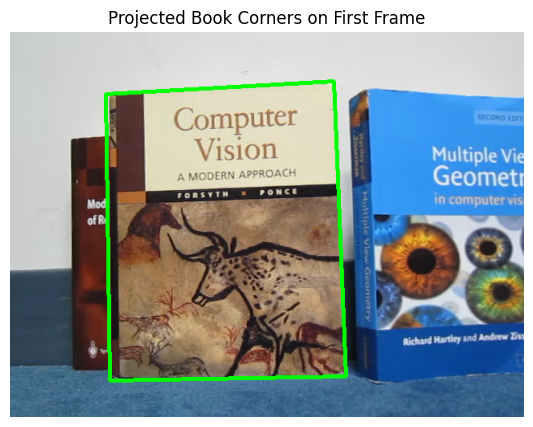

In [32]:
def compute_homography(src_pts, dst_pts):
    """
    Compute the homography matrix H that maps src_pts to dst_pts.

    :param src_pts: Nx2 array of source points
    :param dst_pts: Nx2 array of destination points
    :return: 3x3 homography matrix H
    """
    assert src_pts.shape[0] >= 4 and dst_pts.shape[0] >= 4, "Need at least 4 correspondences"
    assert src_pts.shape == dst_pts.shape

    N = src_pts.shape[0]
    A = []

    for i in range(N):
        x, y = src_pts[i][0], src_pts[i][1]
        x_, y_ = dst_pts[i][0], dst_pts[i][1]

        A.append([x, y, 1, 0, 0, 0, -x * x_, -y * x_, -x_])
        A.append([0, 0, 0, x, y, 1, -x * y_, -y * y_, -y_])

    A = np.array(A)

    # Solve using SVD
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # Normalize so H[2,2] = 1
    return H / H[2, 2]

# Example usage using the matched keypoints from Task 1.1
def get_corresponding_points(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    return src_pts, dst_pts

# Assuming kp1, kp2, good_matches from Task 1.1
src_pts, dst_pts = get_corresponding_points(kp1, kp2, good_matches)
H = compute_homography(src_pts, dst_pts)
print("Homography Matrix:\n", H)

# Optional: verify by warping the corners of book_img
h, w = book_img.shape
book_corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(book_corners, H)

# Draw the projected corners on the first frame
img_with_box = frame.copy()
cv2.polylines(img_with_box, [np.int32(warped_corners)], isClosed=True, color=(0,255,0), thickness=3)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
plt.title("Projected Book Corners on First Frame")
plt.axis("off")
plt.show()

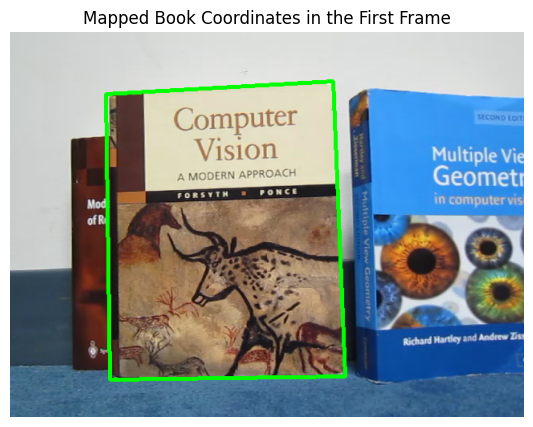

In [33]:
def get_book_corners(book_img):
    """Returns the 4 corners of the book image in (x, y) format."""
    h, w = book_img.shape[:2]
    return np.float32([
        [0, 0],       # Top-left
        [w - 1, 0],   # Top-right
        [w - 1, h - 1],  # Bottom-right
        [0, h - 1]    # Bottom-left
    ]).reshape(-1, 1, 2)

def warp_corners(H, corners):
    """Applies homography to corners and returns warped points."""
    return cv2.perspectiveTransform(corners, H)

def draw_projected_box(image, corners):
    """Draws a polygon from 4 corner points on the image."""
    img_copy = image.copy()
    cv2.polylines(img_copy, [np.int32(corners)], isClosed=True, color=(0, 255, 0), thickness=3)
    return img_copy

# Get the book corners from the book image
book_corners = get_book_corners(book_img)

# Warp the book corners using the homography matrix
warped_book_corners = warp_corners(H, book_corners)

# Draw the mapped corners on the first video frame
frame_with_box = draw_projected_box(frame, warped_book_corners)

# Show the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(frame_with_box, cv2.COLOR_BGR2RGB))
plt.title("Mapped Book Coordinates in the First Frame")
plt.axis('off')
plt.show()

In [ ]:
# Load the first frame from the AR video
cap_ar = cv2.VideoCapture('../assignment_2_materials/ar_source.mov')
ret_ar, ar_frame = cap_ar.read()
cap_ar.release()

if not ret_ar:
    raise ValueError("Could not read AR source video.")


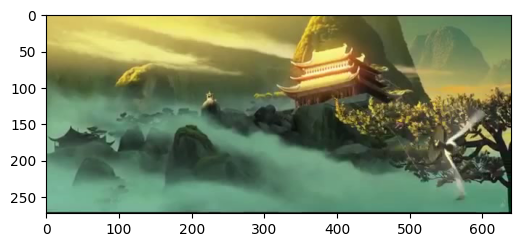

In [39]:
def crop_black_borders(img):
    """
    Automatically crops black borders from the image.
    Works for grayscale or color images.
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Threshold: pixels > 10 are considered "non-black"
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find non-zero coordinates (non-black areas)
    coords = cv2.findNonZero(thresh)

    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        cropped = img[y:y+h, x:x+w]
        return cropped
    else:
        return img  # return as is if nothing is found
crop_1 = crop_black_borders(ar_frame)
# Show the result
plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(crop_1, cv2.COLOR_BGR2RGB))


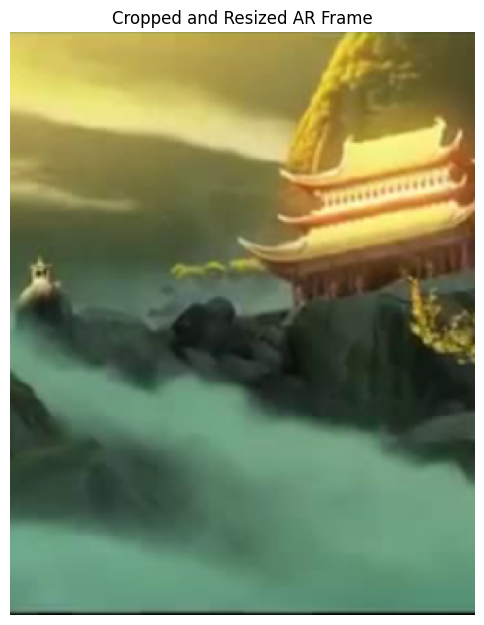

In [42]:
def get_book_dimensions(warped_corners):
    """
    Calculate the width and height of the quadrilateral formed by the corners.
    """
    warped_corners = warped_corners.reshape(4, 2)
    width = int(np.linalg.norm(warped_corners[0] - warped_corners[1]))
    height = int(np.linalg.norm(warped_corners[0] - warped_corners[3]))
    return width, height

def crop_center(img, target_aspect_ratio):
    """
    Crop the center of the image to match the target aspect ratio (w / h).
    """
    h, w = img.shape[:2]
    current_aspect = w / h

    if current_aspect > target_aspect_ratio:
        # Too wide — crop width
        new_w = int(h * target_aspect_ratio)
        x1 = (w - new_w) // 2
        cropped = img[:, x1:x1 + new_w]
    else:
        # Too tall — crop height
        new_h = int(w / target_aspect_ratio)
        y1 = (h - new_h) // 2
        cropped = img[y1:y1 + new_h, :]

    return cropped


# Get book dimensions from warped corners
book_w, book_h = get_book_dimensions(warped_book_corners)
book_aspect_ratio = book_w / book_h

# Crop the AR frame and resize it to match book dimensions
cropped_ar = crop_center(crop_1, book_aspect_ratio)
resized_ar = cv2.resize(cropped_ar, (book_w, book_h))

# Show the result
plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(resized_ar, cv2.COLOR_BGR2RGB))
plt.title("Cropped and Resized AR Frame")
plt.axis('off')
plt.show()


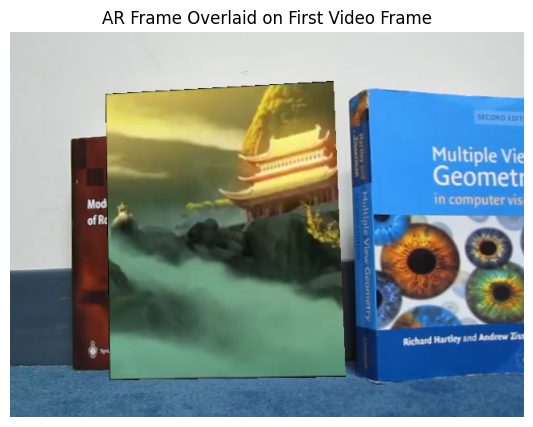

In [43]:
def overlay_ar_on_frame(base_frame, ar_img, target_corners):
    """
    Warps the AR image to the target corners and overlays it on the base frame.
    """
    h, w = ar_img.shape[:2]

    # Define source corners of the AR image
    src_corners = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])

    # Compute homography from AR image to book region
    H_ar = cv2.getPerspectiveTransform(src_corners, target_corners.reshape(4, 2))

    # Warp AR image to fit the book area
    warped_ar = cv2.warpPerspective(ar_img, H_ar, (base_frame.shape[1], base_frame.shape[0]))

    # Create mask for overlay
    mask = np.zeros_like(base_frame, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(target_corners), (255, 255, 255))

    # Combine images using the mask
    inv_mask = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(base_frame, inv_mask)
    foreground = cv2.bitwise_and(warped_ar, mask)
    result = cv2.add(background, foreground)

    return result

# Apply overlay on the first frame
ar_first_overlay = overlay_ar_on_frame(frame, resized_ar, warped_book_corners)

# Show the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(ar_first_overlay, cv2.COLOR_BGR2RGB))
plt.title("AR Frame Overlaid on First Video Frame")
plt.axis('off')
plt.show()


# Do this for ALL FRAMES

In [44]:
# Load book reference image
book_img = cv2.imread('../assignment_2_materials/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
book_kp, book_des = sift.detectAndCompute(book_img, None)

# Re-open video streams
book_cap = cv2.VideoCapture('../assignment_2_materials/book.mov')
ar_cap = cv2.VideoCapture('../assignment_2_materials/ar_source.mov')

# Video properties
fps = int(book_cap.get(cv2.CAP_PROP_FPS))
width = int(book_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(book_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter('output_ar_dynamic.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

frame_idx = 0
while True:
    ret_book, book_frame = book_cap.read()
    ret_ar, ar_frame = ar_cap.read()

    if not ret_book or not ret_ar:
        break

    book_gray = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints in current book frame
    kp2, des2 = sift.detectAndCompute(book_gray, None)

    matches = bf.knnMatch(book_des, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
        # Extract matched points
        src_pts = np.float32([book_kp[m.queryIdx].pt for m in good_matches])
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

        # Compute new homography
        H_frame, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

        # Warp book corners to this frame
        book_corners = get_book_corners(book_img)
        warped_corners = cv2.perspectiveTransform(book_corners, H_frame)

        # Get current book region size
        book_w, book_h = get_book_dimensions(warped_corners)
        aspect_ratio = book_w / book_h if book_h != 0 else 1

        # Crop AR frame dynamically
        cropped_fr = crop_black_borders(ar_frame)
        cropped_ar = crop_center(cropped_fr, aspect_ratio)
        resized_ar = cv2.resize(cropped_ar, (book_w, book_h))

        # Overlay AR on book frame
        result_frame = overlay_ar_on_frame(book_frame, resized_ar, warped_corners)

    else:
        # Fallback: no enough matches, use original frame
        print(f"Frame {frame_idx}: not enough matches, skipping overlay.")
        result_frame = book_frame

    out.write(result_frame)
    frame_idx += 1

book_cap.release()
ar_cap.release()
out.release()
print("✅ Final AR video with dynamic tracking saved as output_ar_dynamic.avi")


✅ Final AR video with dynamic tracking saved as output_ar_dynamic.avi
